In [131]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import flox
import seaborn as sns

from ufs2arco import Layers2Pressure

In [2]:
import graphufs
plt.style.use("graphufs.plotstyle")

/contrib/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [154]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)

rds = rds[[
    "pressfc",
    "tmp",
    "spfh",
    "geopotential",
    "hgtsfc_static",
    "delz",
    "dpres",
]]

In [155]:
random_indices = np.random.randint(
    low=0,
    high=len(rds.time),
    size=(100,),
)

In [156]:
rds = rds.isel(time=random_indices)

/contrib/Tim.Smith/miniconda3/envs/graphufs-cpu/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


In [157]:
rds = rds.rename({
    "pfull": "level",
    "grid_yt": "lat",
    "grid_xt": "lon",
})

In [158]:
rds = rds.load()

Class to compute geopotential (and delz, dpres) on a smaller grid than the original replay

In [159]:
class SmallLayers2Pressure(Layers2Pressure):
    def __init__(self, ak, bk, level):
        self.ak = ak.copy()
        self.bk = bk.copy()
        self.level = level.copy()
        if "kp1" not in self.ak.dims:
            self.ak = self.ak.swap_dims({"phalf": "kp1"})
        if "kp1" not in self.bk.dims:
            self.bk = self.bk.swap_dims({"phalf": "kp1"})
        if "k" not in self.level.dims:
            self.level = self.level.swap_dims({"level": "k"})

Function that creates new dataset, with derived variables

In [180]:
def create_new_dataset(phigh, plow, num_levels, parent):

    # recreate phalf in parent grid
    lp = Layers2Pressure()
    phalf = lp.ak + 100_000*lp.bk
    phalf = phalf / 100
    phalf = phalf.to_dataset(name="phalf").swap_dims({"kp1":"phalf"})["phalf"]

    # get new interfaces
    interfaces = np.linspace(phigh, plow, num_levels+1)
    interfaces = phalf.sel(phalf=interfaces, method="nearest")

    # make a container
    nds = xr.Dataset()
    nds["phalf"] = interfaces
    nds["level"] = xr.DataArray(
        (interfaces[1:].values + interfaces[:-1].values)/2,
        dims=("level",),
        attrs=rds.level.attrs.copy(),
    )
    for key in ["ak", "bk"]:
        nds[key] = getattr(lp,key).sel(kp1=nds["kp1"])
        nds = nds.set_coords(key)

    # get vertical distance
    nds["delz"] = parent["delz"].groupby_bins("level", bins=interfaces).sum()
    new_delz_inverse = 1/nds["delz"]

    # compute finite volume averaging
    vars2d = [x for x in parent.data_vars if "level" not in parent[x].dims]
    vars3d = [x for x in parent.data_vars if x != "delz" and "level" in parent[x].dims]
    for key in vars3d:
        with xr.set_options(keep_attrs=True):
            nds[key] = new_delz_inverse * ( (parent[key]*parent["delz"]).groupby_bins("level", bins=interfaces).sum() )

    nds["level_bins"] = nds["level_bins"].swap_dims({"level_bins": "level"})
    for key in vars3d+["delz"]:
        with xr.set_options(keep_attrs=True):
            nds[key] = nds[key].swap_dims({"level_bins": "level"})
        nds[key].attrs["description"] = "delz weighted average in vertical, new coordinate bounds represented by 'level_bins'"
    for v in vars2d:
        nds[v] = rds[v]
    return nds

## Compare derived vs original/avg'd geopotential

In [161]:
from tqdm import tqdm

In [181]:
all_the_data = {}
for num_levels in tqdm([8, 12, 16, 20, 24]):
    nds = create_new_dataset(
        phigh=100,
        plow=1000,
        num_levels=num_levels,
        parent=rds,
    )
    
    slp = SmallLayers2Pressure(ak=nds.ak, bk=nds.bk, level=nds.level)
    
    nds["delz_derived"] = slp.calc_delz(
        pressfc=nds["pressfc"].reset_coords(drop=True),
        temp=nds["tmp"].reset_coords(drop=True),
        spfh=nds["spfh"].reset_coords(drop=True),
    )
    
    nds["geopotential_derived"] = slp.calc_geopotential(
        hgtsfc=nds["hgtsfc_static"],
        delz=nds["delz_derived"].reset_coords(drop=True),
    )
    diff = nds["geopotential_derived"] - nds["geopotential"]
    nds["geopotential_relerr"] = np.abs(diff) / nds["geopotential"]
    nds["geopotential_log_relerr"] = xr.where(
        nds["geopotential_relerr"] > 1e-6,
        np.log10(nds["geopotential_relerr"].where(nds["geopotential_relerr"]>1e-6)),
        0.,
    )
    all_the_data[num_levels] = nds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:14<00:00, 74.98s/it]


In [182]:
for num_levels, xds in all_the_data.items():
    maxerr = xds["geopotential_relerr"].max().values
    print(f"num_levels = {num_levels}, Max Rel Err = {maxerr:1.1e}")

num_levels = 8, Max Rel Err = 1.5e-02
num_levels = 12, Max Rel Err = 1.6e-02
num_levels = 16, Max Rel Err = 1.5e-02
num_levels = 20, Max Rel Err = 1.6e-02
num_levels = 24, Max Rel Err = 1.6e-02


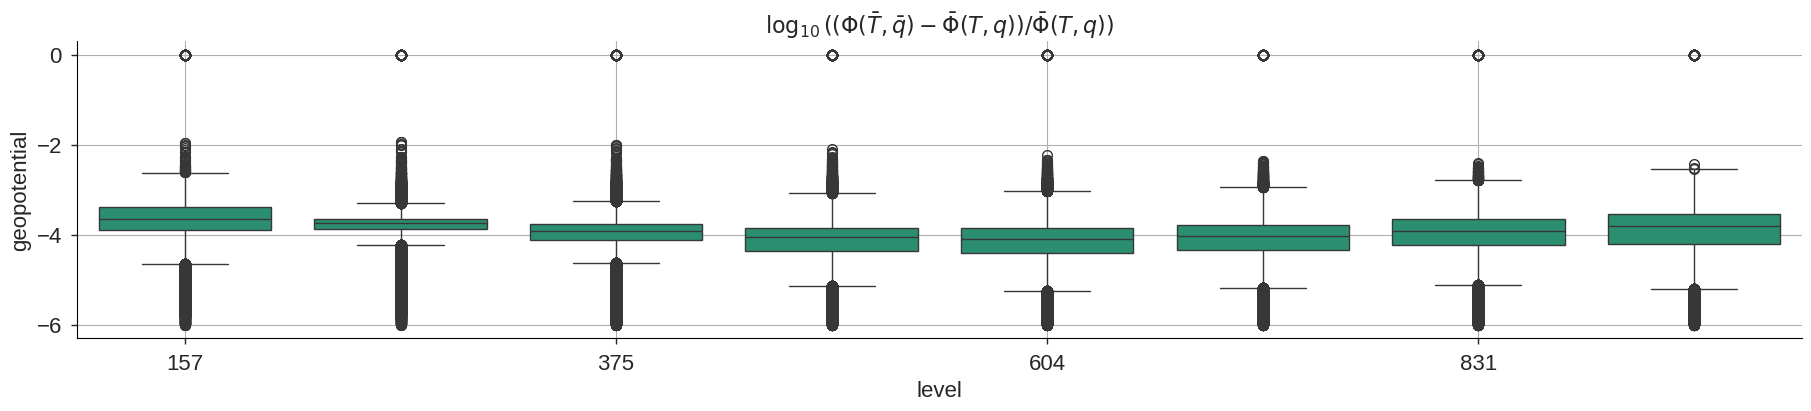

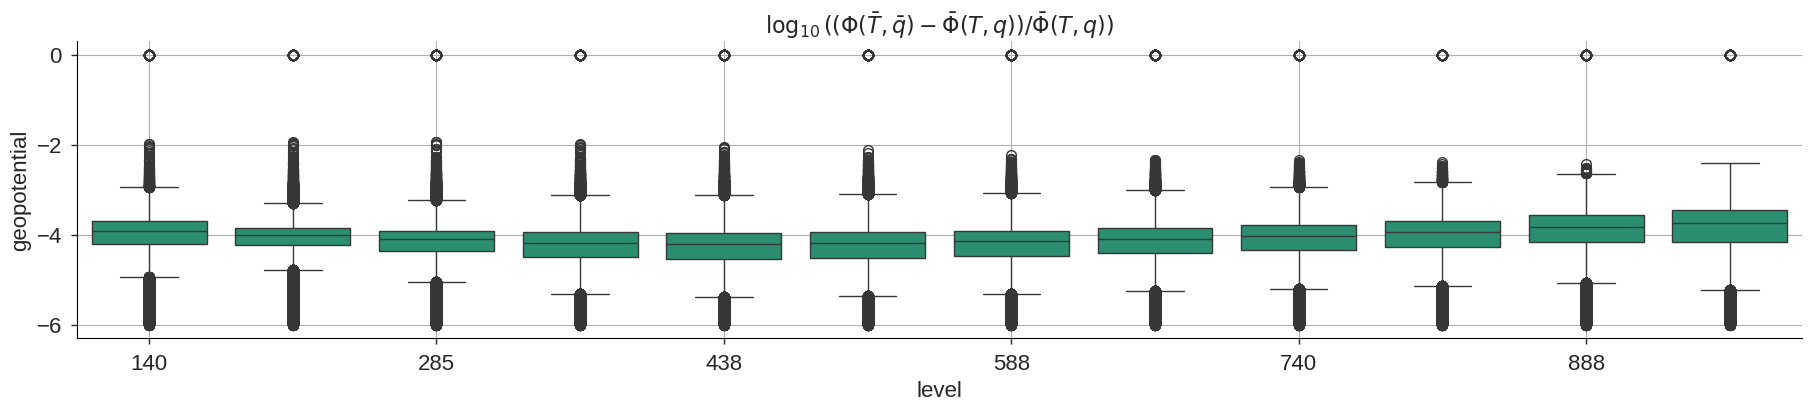

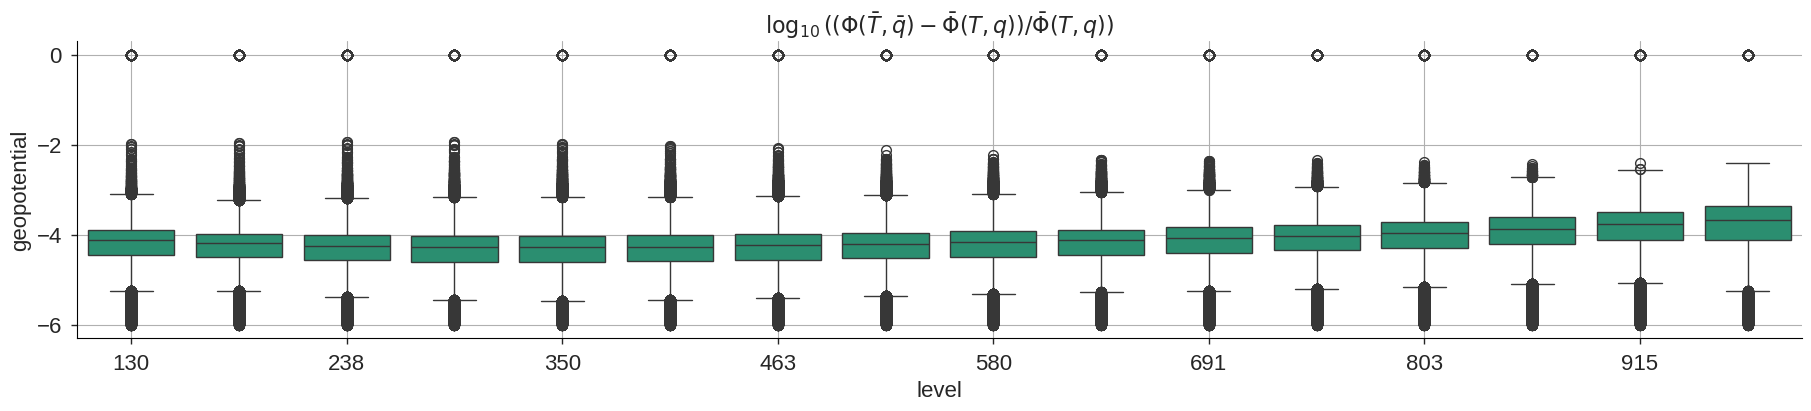

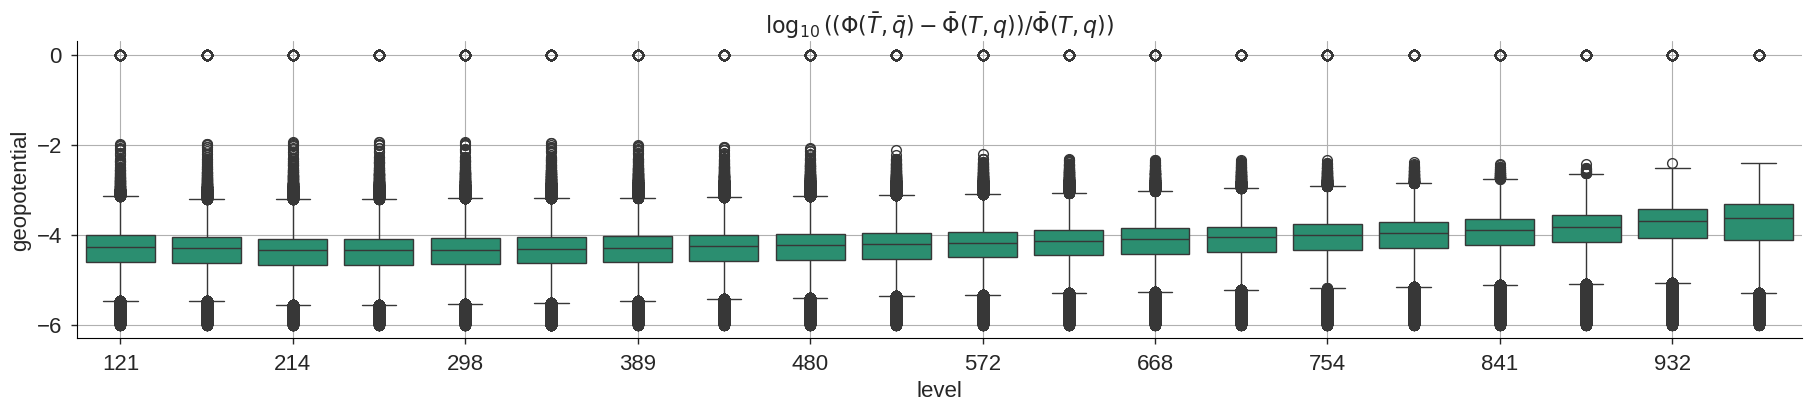

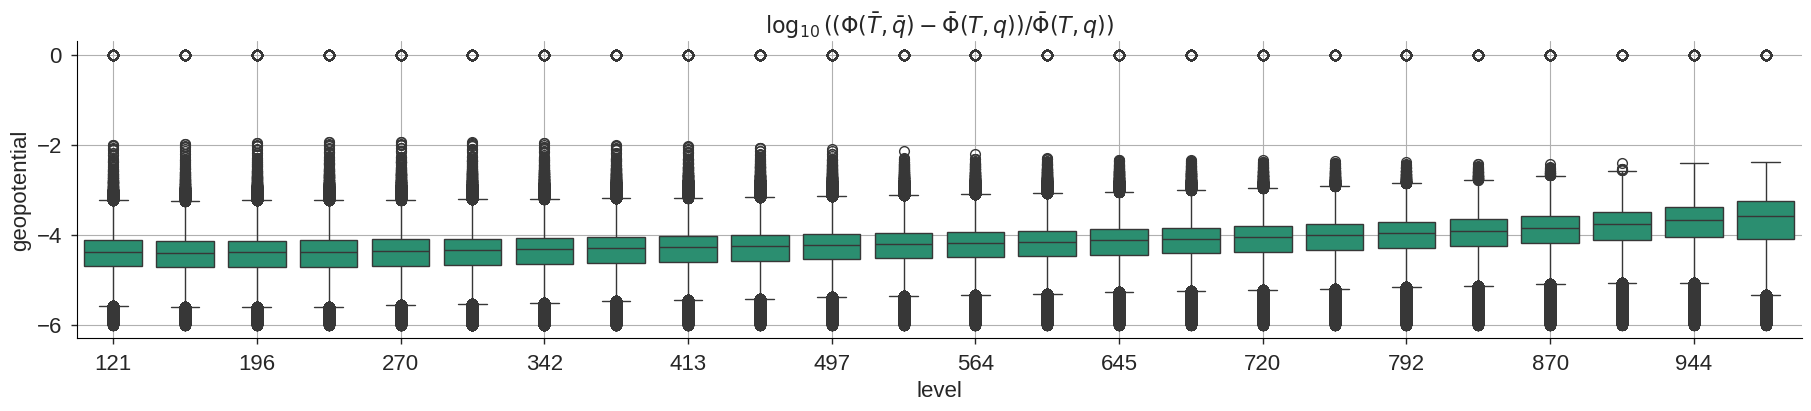

In [183]:
for num_levels, xds in all_the_data.items():
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 4), constrained_layout=True)
    df = xds["geopotential_log_relerr"].isel(time=slice(10)).to_dataset(name="geopotential").to_dataframe()
    sns.boxplot(
        df,
        y="geopotential",
        x="level",
    )
    ax.set(
        title=r"$\log_{10}((\Phi(\bar{T}, \bar{q}) - \bar{\Phi}(T, q))/\bar{\Phi}(T,q))$",
        xticks=np.arange(len(xds.level))[::2],
        xticklabels=[f"{int(x)}" for x in xds.level.values[::2]],
        yticks=[-6, -4, -2, 0],
    )
    ax.grid(visible=True)